# IMNN with TensorFlow 2.0 ($\alpha$)

We can load everything as we expect

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tqdm

And then we set a few IMNN parameters (and data parameters)

In [2]:
input_shape = [10]
n_params = 1
n_summaries = 1

num_updates = 1000
lam = np.float32(2.)
F_ = []
F_v_ = []

### Keras is the way you "should" do things
We can build a model really easily

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(n_summaries)
])
optimiser = tf.keras.optimizers.SGD()
F_arr = tf.keras.metrics.Mean(name='F_arr')
F_validation_arr = tf.keras.metrics.Mean(name='F_validation_arr')

# Functions

Functions act both like actual functions, but also like graph building blocks.

(technically you don't need to put `@tf.function()` before every function - but you need it before certain _important_ ones, but I don't know what they are.

In [4]:
@tf.function()
def Fisher(dmdt, C):
    invC = tf.linalg.inv(C)
    return tf.matmul(tf.matmul(dmdt, invC), tf.transpose(dmdt))

We use normal TensorFlow-like language (whichever you like to write it).

Here is our loss using a bunch of different interesting TensorFlow functions.

In [5]:
@tf.function()
def loss(F, C):
    lndetF = tf.linalg.slogdet(F)
    return tf.subtract(tf.multiply(lam, tf.norm(tf.subtract(C, tf.eye(n_summaries, dtype=tf.float32)), ord="euclidean")), 
                       tf.multiply(lndetF[0], lndetF[1]))

## Now lots of IMNN stuff

Stop me if you want to know more

In [6]:
@tf.function()
def covariance(x):
    m = tf.reduce_mean(x, axis=0, keepdims=True)
    mx = tf.matmul(tf.transpose(m), m)
    vx = tf.divide(tf.matmul(tf.transpose(x), x), tf.cast(tf.shape(x)[0] - 1, tf.float32))
    return tf.subtract(vx, mx)

In [7]:
@tf.function()
def mean_derivative(network_derivative, data_derivative):
    return tf.reduce_mean(
        tf.matmul(data_derivative, 
                  tf.transpose(
                      network_derivative, 
                      tf.concat(
                          [[0], tf.range(2, tf.rank(network_derivative)), [1]], 0))),
        axis=0)

# Automatic differentiation

### Auto-diff is infinitely deep and can be run on anything-(ish) and is really easy to call.

It also has a bunch of easily callable useful functions

On the IMNN-side we can get $\displaystyle\frac{\partial\mu_\mathscr{f}}{\partial\theta_\alpha}$ a bunch of different ways - easily.

In [8]:
@tf.function()
def sim_based_mean(d, dddt):
    with tf.GradientTape() as tape:
        tape.watch(d)
        x = model(d)
    dxdd = tape.batch_jacobian(x, d)
    dmfdt = mean_derivative(dxdd, dddt)
    return x, dmfdt

In [9]:
@tf.function()
def provided_mean(m, dmdt):
    with tf.GradientTape() as tape:
        tape.watch(m)
        mf = model(m)
    dmfdm = tape.batch_jacobian(mf, m)
    dmfdt = mean_derivative(dmfdm, dmdt)
    return dmfdt

In [10]:
@tf.function()
def numerical_mean(dp, dm, dt):
    xp = model(dp)
    xm = model(dm)
    dxdt = tf.divide(tf.subtract(xp, xm), dt)
    return tf.reduce_mean(dxdt, axis=0)

In [11]:
@tf.function()
def summarise(d, dddt=None, m=None, dmdt=None, dp=None, dm=None, dt=None):
    if dddt is not None:
        x, dmfdt = sim_based_mean(d, dddt)
    else:
        x = model(d)
        if m is not None and dmdt is not None:
            dmfdt = provided_mean(m, dmdt)
        elif dp is not None and dm is not None and dt is not None:
            dmfdt = numerical_mean(dp, dm, dt)
        else:
            return None   
    return x, dmfdt, covariance(x)

# Training and testing are defined as their own functions

You can use `tf.GradientTape()` to calculate the gradients to update the weights using apply gradients.

In [12]:
@tf.function()
def train_step(d, lam, dddt=None, m=None, dmdt=None, dp=None, dm=None, dt=None):
    with tf.GradientTape() as g:
        x, dmfdt, Cf = summarise(d, dddt=dddt, m=m, dmdt=dmdt, dp=dp, dm=dm, dt=dt)
        F = Fisher(dmfdt, Cf)
        L = loss(F, Cf)
    gradients = g.gradient(L, model.variables)
    optimiser.apply_gradients(zip(gradients, model.variables))
    F_arr(tf.linalg.det(F))

But you don't need the gradients for testing, so you don't ask for it.

In [13]:
@tf.function()
def test_step(d, dddt=None, m=None, dmdt=None, dp=None, dm=None, dt=None):
    x, dmfdt, Cf = summarise(d, dddt=dddt, m=m, dmdt=dmdt, dp=dp, dm=dm, dt=dt)
    F = Fisher(dmfdt, Cf)
    F_validation_arr(tf.linalg.det(F))

# Make data

Training data

In [14]:
seed = 0

np.random.seed(seed)
d_train = np.random.normal(0., 1., (1000, 10)).astype(np.float32)
m_train = np.mean(d_train, axis=0)
np.random.seed(seed)
dp_train = np.random.normal(0., np.sqrt(1.05), (1000, 1, 10)).astype(np.float32)
np.random.seed(seed)
dm_train = np.random.normal(0., np.sqrt(0.95), (1000, 1, 10)).astype(np.float32)
dt = np.float32(0.1)
dddt_train = (dp_train - dm_train) / dt
dmdt_train = np.mean(dddt_train, axis=0)
np.random.seed()

Testing data

In [15]:
seed = 1

np.random.seed(seed)
d_test = np.random.normal(0., 1., (1000, 10)).astype(np.float32)
m_test = np.mean(d_test, axis=0)
np.random.seed(seed)
dp_test = np.random.normal(0., np.sqrt(1.05), (1000, 1, 10)).astype(np.float32)
np.random.seed(seed)
dm_test = np.random.normal(0., np.sqrt(0.95), (1000, 1, 10)).astype(np.float32)
dddt_test = (dp_test - dm_test) / dt
dmdt_test = np.mean(dddt_test, axis=0)
np.random.seed()

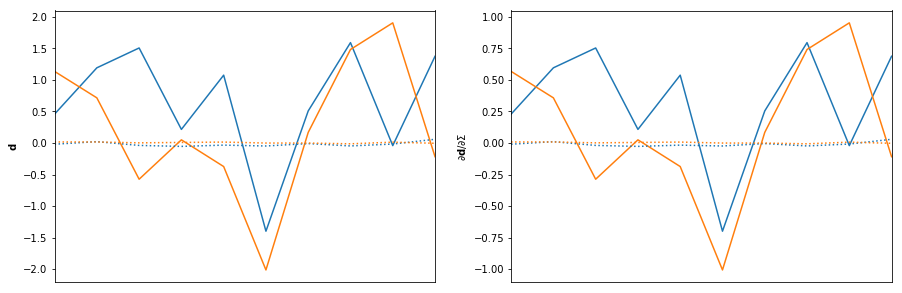

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
train_ind = np.random.randint(1000)
test_ind = np.random.randint(1000)
ax[0].plot(d_train[train_ind], color="C0")
ax[0].plot(d_test[test_ind], color="C1")
ax[0].plot(m_train, color="C0", linestyle=":")
ax[0].plot(m_test, color="C1", linestyle=":")
ax[0].set_ylabel("${\\bf d}$")
ax[0].set_xticks([])
ax[0].set_xlim((0, 9))
ax[1].plot(dddt_train[train_ind, 0], color="C0")
ax[1].plot(dddt_test[test_ind, 0], color="C1")
ax[1].plot(dmdt_train[0], color="C0", linestyle=":")
ax[1].plot(dmdt_test[0], color="C1", linestyle=":")
ax[1].set_ylabel("$\partial{\\bf d}/\partial\\Sigma$")
ax[1].set_xticks([])
ax[1].set_xlim((0, 9));

# Run the training

In [18]:
bar = tqdm.tqdm(range(num_updates), desc="Updates")
for update in bar:
    train_step(d_train, lam, dddt=dddt_train)
    test_step(d_test, dddt=dddt_test)
    F_.append(format(F_arr.result()))
    F_v_.append(format(F_validation_arr.result()))
    bar.set_postfix(F=F_[-1], test_F=F_v_[-1])

Updates:   0%|          | 0/1000 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0322 13:20:51.766164 4623455680 deprecation.py:323] From /Users/charnock/envs/tensorflow-2/lib/python3.7/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
Updates: 100%|██████████| 1000/1000 [00:29<00:00, 33.84it/s, F=5.1374664306640625, test_F=4.118683338165283]


In [ ]:
plt.plot(F_)
plt.plot(F_v_)
plt.xlabel("Weight updates")
plt.ylabel("${\\bf F}_{\\alpha\\beta}$");